# **Library & Depedencies**


In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import MarianMTModel, MarianTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from rich import print
from rich.table import Table
from rich.console import Console
import shutil
import torch
import sacremoses
import sentencepiece
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import numpy as np

c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Preprocessing**

<li>Stop Words Removal</li>
<li>Case Folding</li>


In [2]:
df = pd.read_csv("translated_data.csv")
tiket_df = pd.DataFrame(df)
tqdm.pandas()
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)
display(tiket_df)

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,translated_body,cleaned_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN,The data analysis platform unexpectedly broke ...,data analysis platform unexpectedly broke memo...
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN,Seeking information on digital strategies that...,seeking information digital strategies aid bra...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN,I am contacting you to request information on ...,contacting request information data analytics ...
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN,A media data blocking behavior occurred due to...,media data blocking behavior occurred due unau...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN,"Dear Customer Support, I am reaching out to in...",dear customer support reaching inquire securit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Assistance Needed for IFTTT Docker Integration,I am facing integration problems with IFTTT Do...,I would be happy to assist with the IFTTT Dock...,Problem,Technical Support,low,en,Integration,Disruption,Performance,IT,Tech Support,NaN,NaN,NaN,I am facing integration problems with IFTTT Do...,facing integration problems ifttt docker causi...
19996,Bitten um Unterstützung bei der Integration,"Sehr geehrte Kundenservice, ich möchte die Int...","Sehr geehrte [Name], vielen Dank für Ihren Kon...",Change,Technical Support,medium,de,Integration,Feature,Documentation,Tech Support,NaN,NaN,NaN,NaN,"Dear Customer Service, I would like to request...",dear customer service would like request integ...
19997,NaN,"Hello Customer Support, I am inquiring about t...",We will send you detailed information on plans...,Request,Billing and Payments,low,en,Billing,Payment,Feature,Feedback,Sales,Lead,NaN,NaN,"Hello Customer Support, I am inquiring about t...",hello customer support inquiring billing optio...
19998,Hilfe bei digitalen Strategie-Problemen,Die Qualität unserer digitalen Strategie-Bearb...,Um den digitalen Strategie-Impuls zu überprüfe...,Incident,Product Support,high,de,Feedback,Performance,IT,Tech Support,NaN,NaN,NaN,NaN,The quality of our digital strategy editing ha...,quality digital strategy editing developed neg...


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return print(f"Not cleaned: {""}")
    tokens = word_tokenize(text.lower())
    cleaned_tokens = [
        word for word in tokens if word not in stop_words and word not in punctuation
    ]
    return " ".join(cleaned_tokens)


tiket_df["cleaned_text"] = tiket_df["translated_body"].progress_apply(clean_text)
display(tiket_df[["cleaned_text", "translated_body"]].head(15))

# **Split Data**

Data akan dibagi jadi 80:10:10 (dasarnya apa masih cari lupa nemu di mana). `type`, `queue ` dan `prioritas` masing-masing di-split 80:10:10.


## **1 `priority`**


C:\Users\prith\AppData\Local\Temp\ipykernel_22832\3458849501.py:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  a = sns.countplot(


Ukuran data training (80%): 16000 sampel

Ukuran data validasi (10%): 2000 sampel

Ukuran data testing (10%): 2000 sampel

Distribusi kelas 'priority' di setiap set:

Training:

priority
medium    40.72%
high      39.01%
low       20.28%
Name: proportion, dtype: object

Validation:

priority
medium    40.75%
high       39.0%
low       20.25%
Name: proportion, dtype: object

Testing:

priority
medium    40.7%
high      39.0%
low       20.3%
Name: proportion, dtype: object

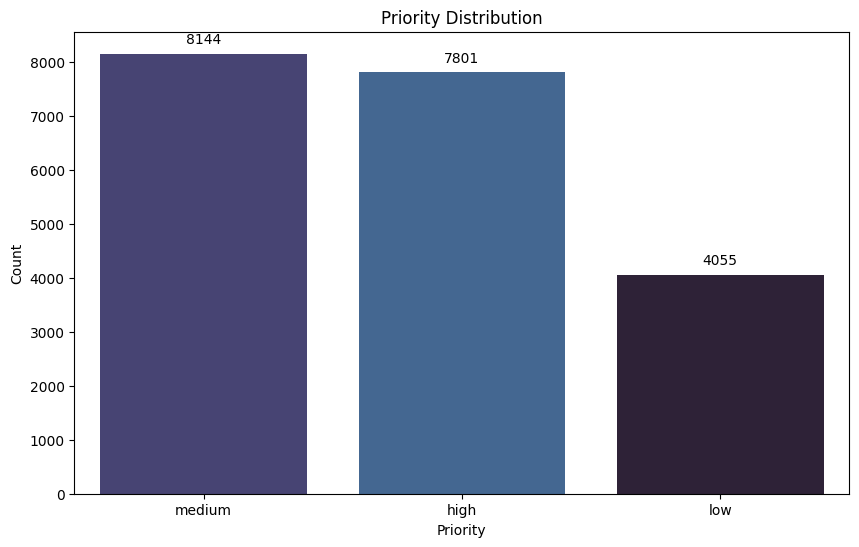

In [ ]:
priority = pd.DataFrame(tiket_df["priority"])
priority_order = df["priority"].value_counts().index

plt.figure(figsize=(10, 6))
a = sns.countplot(
    data=df,
    x="priority",
    hue="priority",
    order=priority_order,
    palette=sns.color_palette("mako"),
)
for container in a.containers:
    a.bar_label(container, fmt="%d", label_type="edge", padding=5)
plt.title("Priority Distribution")
plt.xlabel("Priority")
plt.ylabel("Count")


X = tiket_df["body"]
y = tiket_df["priority"]

# Training
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Testing & Validasi
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Ukuran data training (80%): {len(X_train)} sampel")
print(f"Ukuran data validasi (10%): {len(X_val)} sampel")
print(f"Ukuran data testing (10%): {len(X_test)} sampel")

print("Distribusi kelas 'priority' di setiap set:")
print("Training:")
display(y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nValidation:")
display(y_val.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nTesting:")
display(y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

### **BERT CLS Tokenization**

Tokenisasi untukj `priority` yang sudah di split ke `X_train`,`X_test`,`X_val`


In [63]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_output = tokenizer(
    list(X_train.astype(str).tolist()),
    padding=True,
    truncation=True,
    return_tensors="pt",
)
tiket_df = X_train.to_frame(name="body").reset_index(drop=True)
tiket_df["X_train_token"] = tokenized_output["input_ids"].tolist()
display(X_train.head(5))
display(tiket_df[["X_train_token", "body"]].head(5))

6376    Hello Customer Support, I am contacting you to...
5074    An unauthorized access attempt has been identi...
2674    The data breach happened because the software ...
9706           Unexpected charges appear on the statement
6089    Hello customer support, I am contacting you to...
Name: body, dtype: object

,X_train_token,body
0,"[101, 7592, 8013, 2490, 1010, 1045, 2572, 3967...","Hello Customer Support, I am contacting you to..."
1,"[101, 2019, 24641, 3229, 3535, 2038, 2042, 445...",An unauthorized access attempt has been identi...
2,"[101, 1996, 2951, 12510, 3047, 2138, 1996, 400...",The data breach happened because the software ...
3,"[101, 9223, 5571, 3711, 2006, 1996, 4861, 102,...",Unexpected charges appear on the statement
4,"[101, 7592, 8013, 2490, 1010, 1045, 2572, 3967...","Hello customer support, I am contacting you to..."
